## Quantum Teleportation in Qiskit

see [my website chapter 4](https://dev-undergrad.dev/qiskit/04_quantum_teleportation/) for what this is about.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

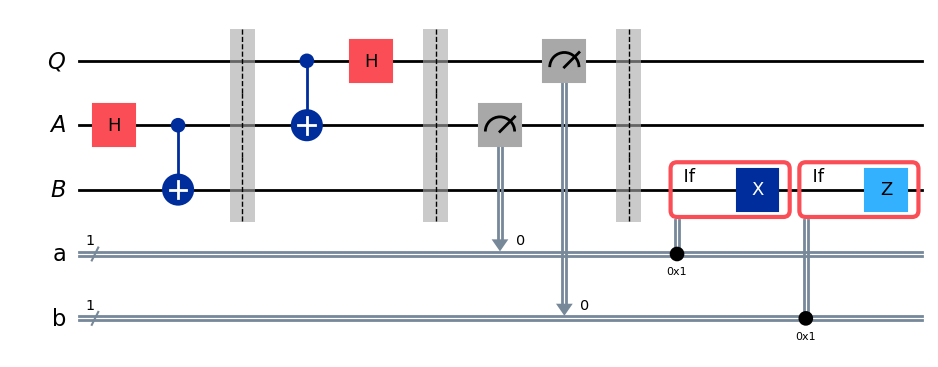

In [15]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B") #ebit0 and ebit1 will be entangled

a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Entangles qubits A and B into the |Φ+> state. 
# Bell circuit from the beginning of Lesson 3. 
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier() # aesthetic barrier

# Alice's operations 
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier() 


# Alice's measurements, placing the results in classical bits 
# `a` and `b` for Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier() 

# Bob uses classical results from `a` and `b` to conditionally 
# apply gates 

with protocol.if_test((a, 1)): 
    protocol.x(ebit1)
with protocol.if_test((b, 1)): 
    protocol.z(ebit1)

protocol.draw('mpl')

To test the protocol works correctly, let's apply a randomly generated single-qubit gate to the intialized $|0\rangle$ state of $Q$ to obtain a random quantum state vector to be teleported. By applying the inverse of that gate to $B$ after the protocol is run, we can verify the state $Q$ was teleported into $B$ by seeing if the inverse gate re-yields the $|0\rangle$ vector. 

In [7]:
random_gate = UGate( 
    theta = random.random() * 2 * pi, 
    phi = random.random() * 2 * pi, 
    lam = random.random() * 2 * pi
)

display(random_gate.to_matrix())

array([[ 0.70324846+0.j        ,  0.70897091-0.05293253j],
       [ 0.33611413-0.62647338j, -0.28541456+0.64272616j]])

Now we'll create a new testing circuit that first applies our random gate to $Q$, *then* runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $B$ and measures it. The outcome should be 0, ***with certainty***. 

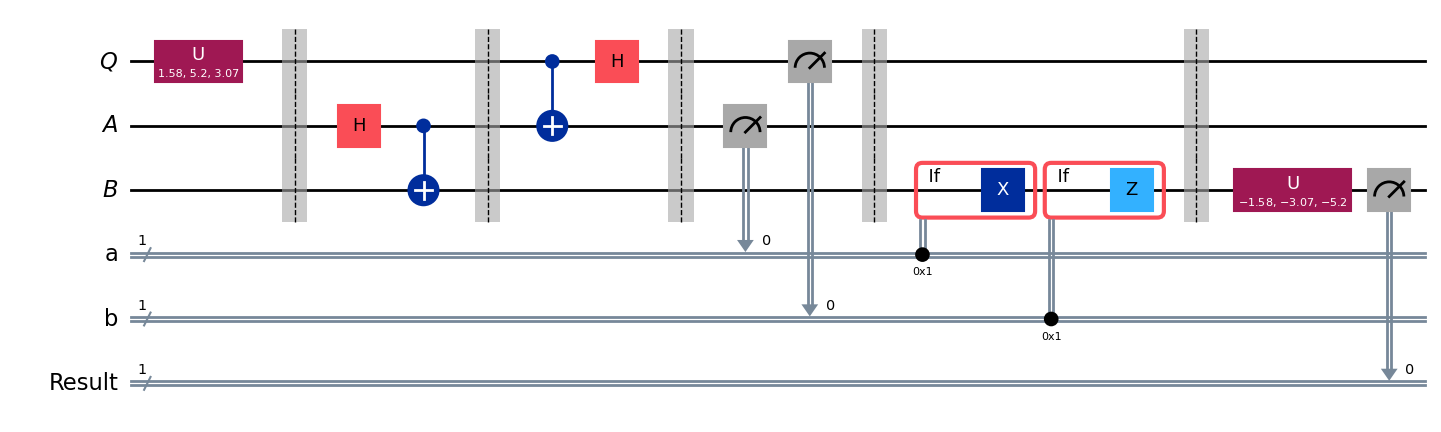

In [8]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

test.draw('mpl')

Finally, let's run the `Aer simulator` on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits. But the bottom/leftmost bit should always be 0 -- indicating $Q$ was succesfully teleported into $B$, while the other two bits should be roughly uniform. 

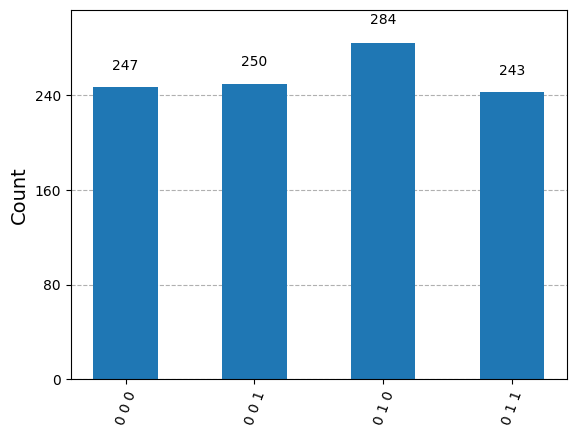

In [12]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)

We can also filter the statistics to focus on just the test result qubit if we wish, like this: 

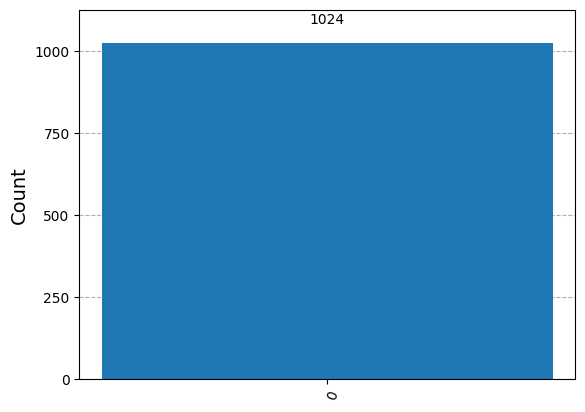

In [13]:
filtered_statistics = marginal_distribution(statistics, [2]) # only 2nd index qubit
plot_histogram(filtered_statistics)